In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

2022-07-18 12:12:29.020261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Num GPUs Available:  1
/device:GPU:0


2022-07-18 12:12:29.025113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:12:29.026273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:12:29.028081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-18 12:12:29.029791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import h5py

import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Input, Lambda, LeakyReLU, Add, Dense, Activation, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform, constant, TruncatedNormal

%matplotlib inline

In [3]:
with h5py.File('../processed_data/np_gan_standard.h5', 'r') as hf:
    data_lr = hf['np_lr'][:]
    data_lr_mean = hf['np_lr_mean'][:]
    data_lr_stddev = hf['np_lr_stddev'][:]
    data_hr = hf['np_hr'][:]
    data_hr_mean = hf['np_hr_mean'][:]
    data_hr_stddev = hf['np_hr_stddev'][:]

In [4]:
print(data_lr.shape)
print(data_lr_mean)
print(data_lr_stddev)
print('\n')
print(data_hr.shape)
print(data_hr_mean)
print(data_hr_stddev)  

(8520, 96, 96, 2)
[ 0.7051484 -1.0147774]
[3.1869051 2.8827915]


(8520, 192, 192, 2)
[ 0.701198  -1.0068085]
[3.149407  2.8781955]


# First Make sure we can recreate the old image

In [5]:
ds_lr = xr.load_dataset('../processed_data/perdigao_low_res_1H_2020.nc')
ds_hr = xr.load_dataset('../processed_data/perdigao_high_res_1H_2020.nc')

In [6]:
print(data_hr[0].shape)

(192, 192, 2)


In [7]:
data_hr_re = data_hr * data_hr_stddev + data_hr_mean

In [8]:
print(data_hr_re.shape)

(8520, 192, 192, 2)


In [9]:
print(np.max(data_hr_re[:,:,:,0] - ds_hr["u"].to_numpy()))

1.9073486e-06


# Define and load the model

In [10]:
def generator(input_shape = (96, 96, 2), nf = 64, r = 2):
    """
    Arguments:
    input_shape -- shape of the images of the dataset, H*W*C
    nf -- integer, the number of filters in all convT layer before super-resolution step
    r -- integer, resolution ratio between output and input

    Returns:
    model -- a Model() instance in Keras
    """
    
    C0 = input_shape[2]
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Define kernel size and stride used
    k, stride = 3, 1
    
    # Shall we use a mirror padding and finally cutoff the edge, like the paper does? FIXME
    X = Conv2DTranspose(filters=nf, kernel_size=(k, k), strides=(stride, stride), padding='same')(X_input)
    # Shall we use relu, or leaky_relu? FIXME
    X = Activation('relu')(X)

    skip_connection = X
    
    for i in range(16):
        X_shortcut = X
        
        X = Conv2DTranspose(filters=nf, kernel_size=(k, k), strides=(stride, stride), padding='same')(X)
        X = Activation('relu')(X)
        X = Conv2DTranspose(filters=nf, kernel_size=(k, k), strides=(stride, stride), padding='same')(X)
        X = Add()([X, X_shortcut])
        # Are we missing a relu activation here, if we follow the resnet paper? FIXME
    
    X = Conv2DTranspose(filters=nf, kernel_size=(k, k), strides=(stride, stride), padding='same')(X)
    X = Add()([X, skip_connection])
    
    # Start to perform sr
    nf_sr = (r**2) * nf
    X = Conv2DTranspose(filters=nf_sr, kernel_size=(k, k), strides=(stride, stride), padding='same')(X)
    
    sub_layer = Lambda(lambda x:tf.nn.depth_to_space(x,r))
    X = sub_layer(X)
    X = Activation('relu')(X)
    
    X = Conv2DTranspose(filters=C0, kernel_size=(k, k), strides=(stride, stride), padding='same')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [11]:
gen_model_pretrain = generator(input_shape = (96, 96, 2))
print(gen_model_pretrain.summary())

gen_model_pretrain.load_weights("generator_pretrain/saved-model-0720.hdf5")

gen_model = generator(input_shape = (96, 96, 2))
print(gen_model.summary())

gen_model = tf.keras.models.load_model('gan_train/gen-model-epoch-316.h5')

2022-07-18 12:12:35.571769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:12:35.572952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:12:35.574052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:12:35.575173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 12:12:35.576270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 2)]  0           []                               
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 96, 96, 64)  1216        ['input_1[0][0]']                
 ose)                                                                                             
                                                                                                  
 activation (Activation)        (None, 96, 96, 64)   0           ['conv2d_transpose[0][0]']       
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 96, 96, 64)  36928       ['activation[0][0]']         

                                                                                                  
 add_6 (Add)                    (None, 96, 96, 64)   0           ['conv2d_transpose_14[0][0]',    
                                                                  'add_5[0][0]']                  
                                                                                                  
 conv2d_transpose_15 (Conv2DTra  (None, 96, 96, 64)  36928       ['add_6[0][0]']                  
 nspose)                                                                                          
                                                                                                  
 activation_8 (Activation)      (None, 96, 96, 64)   0           ['conv2d_transpose_15[0][0]']    
                                                                                                  
 conv2d_transpose_16 (Conv2DTra  (None, 96, 96, 64)  36928       ['activation_8[0][0]']           
 nspose)  

                                                                                                  
 activation_15 (Activation)     (None, 96, 96, 64)   0           ['conv2d_transpose_29[0][0]']    
                                                                                                  
 conv2d_transpose_30 (Conv2DTra  (None, 96, 96, 64)  36928       ['activation_15[0][0]']          
 nspose)                                                                                          
                                                                                                  
 add_14 (Add)                   (None, 96, 96, 64)   0           ['conv2d_transpose_30[0][0]',    
                                                                  'add_13[0][0]']                 
                                                                                                  
 conv2d_transpose_31 (Conv2DTra  (None, 96, 96, 64)  36928       ['add_14[0][0]']                 
 nspose)  

                                                                                                  
 conv2d_transpose_43 (Conv2DTra  (None, 96, 96, 64)  36928       ['add_19[0][0]']                 
 nspose)                                                                                          
                                                                                                  
 activation_22 (Activation)     (None, 96, 96, 64)   0           ['conv2d_transpose_43[0][0]']    
                                                                                                  
 conv2d_transpose_44 (Conv2DTra  (None, 96, 96, 64)  36928       ['activation_22[0][0]']          
 nspose)                                                                                          
                                                                                                  
 add_20 (Add)                   (None, 96, 96, 64)   0           ['conv2d_transpose_44[0][0]',    
          

 conv2d_transpose_58 (Conv2DTra  (None, 96, 96, 64)  36928       ['activation_29[0][0]']          
 nspose)                                                                                          
                                                                                                  
 add_27 (Add)                   (None, 96, 96, 64)   0           ['conv2d_transpose_58[0][0]',    
                                                                  'add_26[0][0]']                 
                                                                                                  
 conv2d_transpose_59 (Conv2DTra  (None, 96, 96, 64)  36928       ['add_27[0][0]']                 
 nspose)                                                                                          
                                                                                                  
 activation_30 (Activation)     (None, 96, 96, 64)   0           ['conv2d_transpose_59[0][0]']    
          

In [12]:
def discriminator(input_shape = (192, 192, 2)):
    """
    Arguments:
    input_shape -- shape of the images of the dataset, H*W*C

    Returns:
    model -- a Model() instance in Keras
    """
    
    C0 = input_shape[2]
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    #conv1
    X = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="same")(X_input)
    X = LeakyReLU(alpha=0.2)(X)
    
    #conv2
    X = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding="same")(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    #conv3
    X = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same")(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    #conv4
    X = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding="same")(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    #conv5
    X = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same")(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    #conv6
    X = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding="same")(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    #conv7
    X = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same")(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    #conv8
    X = Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding="same")(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Flatten()(X)
    
    #first fully-connect
    k_init = TruncatedNormal(stddev=0.02)
    X = Dense(units=1024, kernel_initializer=k_init)(X)
    X = LeakyReLU(alpha=0.2)(X)
    
    #second fully-connect, no activation FIXME
    X = Dense(units=1, kernel_initializer=k_init)(X)
    
    model = Model(inputs = X_input, outputs = X)
    return model

In [13]:
disc_model = discriminator(input_shape = (192, 192, 2))
print(disc_model.summary())

disc_model = tf.keras.models.load_model('gan_train/disc-model-epoch-216.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 192, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 32)      608       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 192, 192, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 96, 96, 64)        0   

# Next try to apply this to a random test image

In [14]:
#First split data into train+validation and test set
x_train, x_test, y_train, y_test = train_test_split(data_lr, data_hr, test_size=0.2, random_state=42)

#Next split training again into train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

print(np.max(x_train), np.max(x_val), np.max(x_test), np.min(x_train), np.min(x_val), np.min(x_test))
print(np.max(y_train), np.max(y_val), np.max(y_test), np.min(y_train), np.min(y_val), np.min(y_test))

(5112, 96, 96, 2)
(1704, 96, 96, 2)
(1704, 96, 96, 2)
(5112, 192, 192, 2)
(1704, 192, 192, 2)
(1704, 192, 192, 2)
6.890482 5.989441 5.7024393 -5.4777956 -5.0524907 -5.5057893
7.035497 5.8600492 6.0442076 -5.315754 -5.2317853 -5.2996855


In [15]:
# Choose the image idx we want to test on

idx = 42
lr_ex_pre = x_test[idx]
hr_ex_pre = y_test[idx]
print(lr_ex_pre.shape, hr_ex_pre.shape)

(96, 96, 2) (192, 192, 2)


In [16]:
lr_ex = lr_ex_pre * data_lr_stddev + data_lr_mean
hr_ex = hr_ex_pre * data_hr_stddev + data_hr_mean

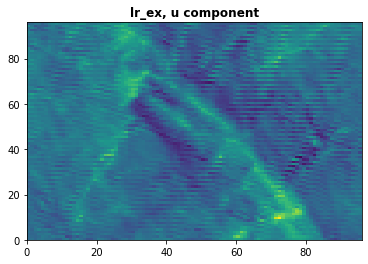

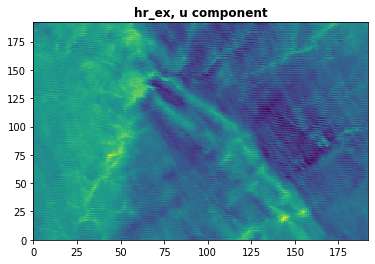

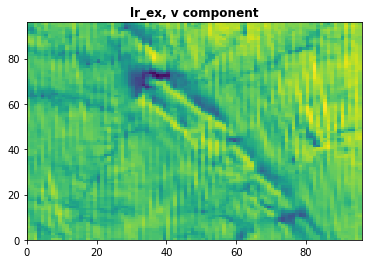

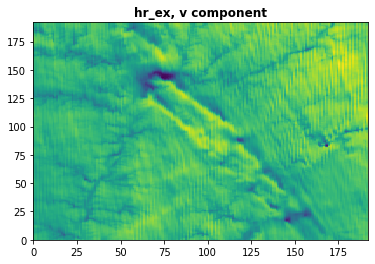

In [17]:
plt.pcolormesh(lr_ex[:,:,0])
plt.title('lr_ex, u component', fontweight ="bold")
plt.show()

plt.pcolormesh(hr_ex[:,:,0])
plt.title('hr_ex, u component', fontweight ="bold")
plt.show()

plt.pcolormesh(lr_ex[:,:,1])
plt.title('lr_ex, v component', fontweight ="bold")
plt.show()

plt.pcolormesh(hr_ex[:,:,1])
plt.title('hr_ex, v component', fontweight ="bold")
plt.show()

# Then try to regenerate image generated from model

In [18]:
lr_ex_in = lr_ex.reshape(1, 96, 96, 2)
print(lr_ex_in.shape)

(1, 96, 96, 2)


In [19]:
sr_pretrain_ex_pre = gen_model_pretrain.predict(lr_ex_in)

2022-07-18 12:13:22.126576: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 2s 2s/step


In [20]:
sr_gan_ex_pre = gen_model.predict(lr_ex_in)

1/1 [==============================] - 0s 323ms/step


In [21]:
sr_pretrain_ex = sr_pretrain_ex_pre[0] * data_hr_stddev + data_hr_mean
print(sr_pretrain_ex.shape)

sr_gan_ex = sr_gan_ex_pre[0] * data_hr_stddev + data_hr_mean
print(sr_gan_ex.shape)

(192, 192, 2)
(192, 192, 2)


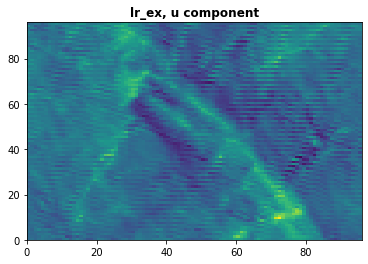

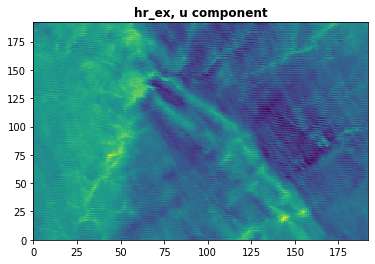

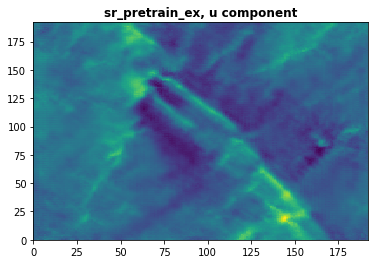

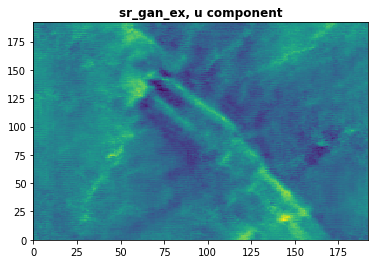

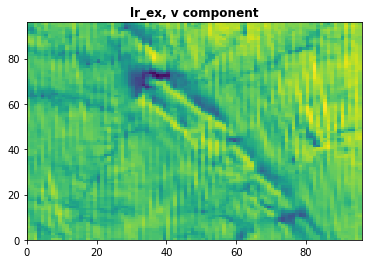

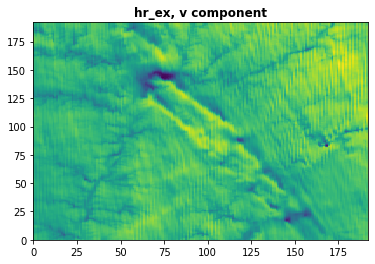

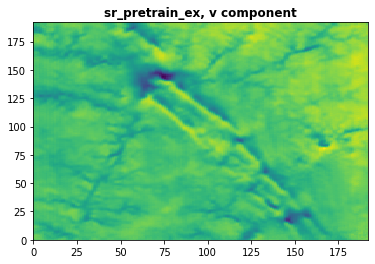

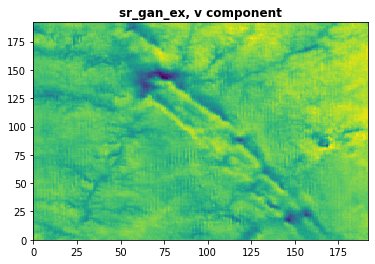

In [22]:
plt.pcolormesh(lr_ex[:,:,0])
plt.title('lr_ex, u component', fontweight ="bold")
plt.show()

plt.pcolormesh(hr_ex[:,:,0])
plt.title('hr_ex, u component', fontweight ="bold")
plt.show()

plt.pcolormesh(sr_pretrain_ex[:,:,0])
plt.title('sr_pretrain_ex, u component', fontweight ="bold")
plt.show()

plt.pcolormesh(sr_gan_ex[:,:,0])
plt.title('sr_gan_ex, u component', fontweight ="bold")
plt.show()


plt.pcolormesh(lr_ex[:,:,1])
plt.title('lr_ex, v component', fontweight ="bold")
plt.show()


plt.pcolormesh(hr_ex[:,:,1])
plt.title('hr_ex, v component', fontweight ="bold")
plt.show()


plt.pcolormesh(sr_pretrain_ex[:,:,1])
plt.title('sr_pretrain_ex, v component', fontweight ="bold")
plt.show()


plt.pcolormesh(sr_gan_ex[:,:,1])
plt.title('sr_gan_ex, v component', fontweight ="bold")
plt.show()